<a href="https://colab.research.google.com/github/Redoy03/Basic_Python/blob/main/Facial_Expression_Recognition_for_Mental_Health%C2%A0Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
#প্রথমে গুগল ড্রাইভে আপলোড দিয়েছি ফাইল যার নামঃImage Processing.zip
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
#গুগল কোলেভে আপ দেওয়ার পর ওইটাকে আনজিপ করলাম
!unzip /content/drive/MyDrive/Image\ Processing.zip -d /content/

Archive:  /content/drive/MyDrive/Image Processing.zip
   creating: /content/Image Processing/
   creating: /content/Image Processing/Anger/
  inflating: /content/Image Processing/Anger/Anger.jpg  
  inflating: /content/Image Processing/Anger/Anger1.jpg  
  inflating: /content/Image Processing/Anger/Anger10.jpg  
  inflating: /content/Image Processing/Anger/Anger11.jpg  
  inflating: /content/Image Processing/Anger/Anger12.jpg  
  inflating: /content/Image Processing/Anger/Anger13.jpg  
  inflating: /content/Image Processing/Anger/Anger14.jpg  
  inflating: /content/Image Processing/Anger/Anger15.jpg  
  inflating: /content/Image Processing/Anger/Anger16.jpg  
  inflating: /content/Image Processing/Anger/Anger17.jpg  
  inflating: /content/Image Processing/Anger/Anger18.jpg  
  inflating: /content/Image Processing/Anger/Anger2.jpg  
  inflating: /content/Image Processing/Anger/Anger3.jpg  
  inflating: /content/Image Processing/Anger/Anger4.jpg  
  inflating: /content/Image Processing/A

In [4]:
import os
import zipfile

# Google Drive এ থাকা Zip ফাইল
zip_path = "/content/drive/MyDrive/Image Processing.zip"

# Extract করার লোকেশন
extract_path = "/content/Image_Processing"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# প্রতিটি ফোল্ডার ও ফাইল কাউন্ট
for root, dirs, files in os.walk(extract_path):
    if files:  # যদি ফোল্ডারে ফাইল থাকে
        rel_path = os.path.relpath(root, extract_path)  # extract_path বাদ দিয়ে শুধু ভেতরের path
        print(rel_path, ":", len(files))


Image Processing/Contempt : 19
Image Processing/Disgust : 19
Image Processing/Surprised : 19
Image Processing/Happy : 19
Image Processing/Sad : 19
Image Processing/Fear : 19
Image Processing/Anger : 19
Image Processing/Neutral : 19


#Augmentation

In [5]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np

dataset_path = "/content/Image_Processing/Image Processing"  # এখানে তোমার আসল dataset ফোল্ডার দিন

target_size = (224, 224)  # বড় সাইজ নিলে model ভালো কাজ করবে
target_count = 1000       # প্রতিটি ক্লাসে কমপক্ষে 1000 ছবি হবে

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_class(class_name, target=target_count):
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    current_count = len(images)
    i = 0
    print(f"{class_name}: start {current_count}")

    while current_count < target:
        img_path = os.path.join(class_path, images[i % len(images)])
        img = load_img(img_path, target_size=target_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        aug_iter = datagen.flow(
            x,
            batch_size=1,
            save_to_dir=class_path,
            save_prefix=f"aug_{current_count}",
            save_format='jpeg'
        )
        next(aug_iter)

        current_count += 1
        i += 1

    print(f"{class_name}: done {current_count}")

# সব ক্লাস balance করা
for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    if os.path.isdir(class_path):
        augment_class(cls, target_count)


Contempt: start 19
Contempt: done 1000
Disgust: start 19
Disgust: done 1000
Surprised: start 19
Surprised: done 1000
Happy: start 19
Happy: done 1000
Sad: start 19
Sad: done 1000
Fear: start 19
Fear: done 1000
Anger: start 19
Anger: done 1000
Neutral: start 19
Neutral: done 1000


data generator

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

data_path = "/content/Image_Processing/Image Processing"

print("Available folders:", os.listdir(data_path))  # চেক করবে ক্লাস ফোল্ডার আছে কিনা

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

try:
    num_classes = train_gen.num_classes   # নতুন TF version
except:
    num_classes = len(train_gen.class_indices)  # fallback

print("Classes:", train_gen.class_indices)
print("Total classes:", num_classes)


Available folders: ['Contempt', 'Disgust', 'Surprised', 'Happy', 'Sad', 'Fear', 'Anger', 'Neutral']
Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Classes: {'Anger': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprised': 7}
Total classes: 8


In [7]:
import os

dataset_path = "/content/Image_Processing/Image Processing"

for cls in os.listdir(dataset_path):
    cls_path = os.path.join(dataset_path, cls)
    if os.path.isdir(cls_path):  # শুধু ফোল্ডার নেবে
        files = [f for f in os.listdir(cls_path) if os.path.isfile(os.path.join(cls_path, f))]
        print(cls, ":", len(files))


Contempt : 1000
Disgust : 1000
Surprised : 1000
Happy : 1000
Sad : 1000
Fear : 1000
Anger : 1000
Neutral : 1000


In [8]:
# Google Drive এ move করা
!cp /content/Image_Processing_Augmented.zip /content/drive/MyDrive/

cp: cannot stat '/content/Image_Processing_Augmented.zip': No such file or directory


In [9]:
import shutil

# Augmented dataset কে zip আকারে বানানো
shutil.make_archive("/content/Image_Processing_Augmented", 'zip', "/content/Image_Processing/Image Processing")

'/content/Image_Processing_Augmented.zip'

CNN Model

In [10]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam

# Ensure num_classes is defined (it should be from previous cells)
if 'num_classes' not in locals():
    num_classes = len(train_gen.class_indices)

# Assuming target_size was used for image processing
INPUT_SHAPE = (224, 224, 3) # Or target_size + (3,) if target_size is defined as a tuple

cnn_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=INPUT_SHAPE),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(num_classes, activation='softmax')
])

cnn_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

cnn_model.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 8)              │         4,104 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,400,200 (169.37 MB)

 Trainable params: 44,400,200 (169.37 MB)

 Non-trainable params: 0 (0.00 B)

Training CNN Model

In [11]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)

In [13]:
print('Starting CNN model training...')
history_cnn = cnn_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=30, # You can adjust the number of epochs
    callbacks=[early_stop] # Use the early stopping callback
)
print('CNN model training finished.')

Starting CNN model training...
Epoch 1/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 855s 4s/step - accuracy: 0.8960 - loss: 0.3482 - val_accuracy: 0.5025 - val_loss: 1.5714
Epoch 2/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 856s 4s/step - accuracy: 0.9250 - loss: 0.2643 - val_accuracy: 0.5063 - val_loss: 1.6419
Epoch 3/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 847s 4s/step - accuracy: 0.9477 - loss: 0.1953 - val_accuracy: 0.5094 - val_loss: 1.7103
Epoch 4/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 846s 4s/step - accuracy: 0.9625 - loss: 0.1461 - val_accuracy: 0.5219 - val_loss: 1.7647
Epoch 5/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 832s 4s/step - accuracy: 0.9714 - loss: 0.1158 - val_accuracy: 0.5219 - val_loss: 1.8584
Epoch 6/30
200/200 ━━━━━━━━━━━━━━━━━━━━ 829s 4s/step - accuracy: 0.9755 - loss: 0.0939 - val_accuracy: 0.5244 - val_loss: 1.8673
CNN model training finished.


model_resnet

In [14]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# নিশ্চিত কর num_classes define আছে
num_classes = len(train_gen.class_indices)

# Base Model
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))
for layer in resnet_base.layers:
    layer.trainable = False   # freeze layers

# Top Layers
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

# Final Model
resnet_model = Model(inputs=resnet_base.input, outputs=output)

# Compile
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,904 (94.00 MB)

 Trainable params: 1,053,192 (4.02 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

model efficientnet

training resnet

In [15]:
# --- Define Model Parameters (এখানে num_classes 10 এর বদলে 8 করে দিন) ---
INPUT_SHAPE = (224, 224, 3)
num_classes = 8 # <--- এই পরিবর্তনটি করুন

# ... (বাকি মডেল ডেফিনেশন এবং কম্পাইল কোড একই থাকবে) ...

# Add a final classification layer (এটি এখন num_classes=8 আউটপুট দেবে)
predictions = Dense(num_classes, activation='softmax')(x)
# ...

training efficientnet

ensemble

In [16]:
import numpy as np
from tensorflow.keras.preprocessing import image

def ensemble_predict(img_path):
    img = image.load_img(img_path, target_size=(224,224))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Only use ResNet model for prediction
    pred_resnet = resnet_model.predict(img_array)

    final_pred = pred_resnet # Now only ResNet's prediction
    class_idx = np.argmax(final_pred)
    class_name = list(train_gen.class_indices.keys())[class_idx]

    return class_name, final_pred

evaluation

In [17]:
# নতুন ৮-ক্লাসের মডেলটি সেভ করুন
resnet_model.save('resnet_model_8_classes.h5')

# এনসেম্বল কোড চালানোর আগে শুধু নতুন মডেলটি লোড করুন
from tensorflow.keras.models import load_model
resnet_model = load_model('resnet_model_8_classes.h5')
# eff_model = load_model('eff_model.h5')

save_models

In [18]:
resnet_model.save("/content/ResNet_FER.h5")
print("Models saved successfully ✅")

Models saved successfully ✅


plot_graphs

In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout # Dropout যোগ করা হয়েছে
from tensorflow.keras.applications import ResNet50
import numpy as np
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping # Callbacks যোগ করা হয়েছে

# --- গুরুত্বপূর্ণ হাইপারপ্যারামিটার ---
num_classes = 8
INPUT_SHAPE = (224, 224, 3)
LEARNING_RATE = 1e-4 # ছোট লার্নিং রেট ট্রেনিং-এর জন্য ভালো
EPOCHS = 50 # পর্যাপ্ত সংখ্যক ইপক সেট করা হয়েছে (যদি EarlyStopping না লাগে)
BATCH_SIZE = 32

# ----------------------------------------------------
# 1. ResNet মডেলের উন্নত কাঠামো তৈরি (Transfer Learning)
# ----------------------------------------------------

# বেস মডেল তৈরি: weights='imagenet' ব্যবহার করুন
base_model_temp = ResNet50(weights='imagenet',
                           include_top=False, # টপ লেয়ার বাদ
                           input_shape=INPUT_SHAPE)

# বেস মডেলের লেয়ারগুলি প্রথমে নন-ট্রেনিংএবল (Frozen) রাখা
for layer in base_model_temp.layers:
    layer.trainable = False

# নতুন 8-ক্লাসের টপ লেয়ার যোগ (Custom Head)
x = base_model_temp.output
x = GlobalAveragePooling2D()(x)

# ★ ড্রপআউট যোগ করা হয়েছে (Overfitting কমাতে সাহায্য করে)
x = Dropout(0.5)(x)

predictions = Dense(num_classes, activation='softmax')(x)
resnet_model_improved = Model(inputs=base_model_temp.input, outputs=predictions)

# মডেল কম্পাইল করুন
resnet_model_improved.compile(
    optimizer=Adam(learning_rate=LEARNING_RATE),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ----------------------------------------------------
# 2. কলব্যাকস (Callbacks) এবং প্রশিক্ষণের প্রস্তুতি
# ----------------------------------------------------

# ★ আর্লি স্টপিং (Early Stopping): অ্যাকুরেসি বাড়ানো বন্ধ করলে ট্রেনিং থামিয়ে দেবে।
early_stopping = EarlyStopping(
    monitor='val_loss', # ভ্যালিডেশন লস দেখুন
    patience=10,        # 10 ইপক পর্যন্ত অপেক্ষা করুন
    restore_best_weights=True # সবচেয়ে ভালো ওজন লোড করুন
)

# ★ মডেল চেকপয়েন্ট (Model Checkpoint): সবচেয়ে ভালো মডেল সেভ করে রাখা
model_checkpoint = ModelCheckpoint(
    'best_resnet_model.h5',
    monitor='val_accuracy', # ভ্যালিডেশন অ্যাকুরেসি দেখুন
    save_best_only=True,
    mode='max',
    verbose=1
)

# ----------------------------------------------------
# 3. মডেল প্রশিক্ষণ (Training - The Missing Step)
# ----------------------------------------------------

# ★ আসল সমস্যা: আপনার কোড ট্রেনিং-এর অংশটি দেখায়নি।
# যদি আপনি মডেলকে প্রশিক্ষিত না করেন, তবে অ্যাকুরেসি random-এর কাছাকাছিই থাকবে (1/8 = 12.5% বা তারও কম)।
# আপনার মডেলকে অবশ্যই ডেটা দিয়ে প্রশিক্ষণ দিতে হবে।
# (ধরে নিচ্ছি আপনার কাছে 'train_gen' এবং 'val_gen' আছে, যা Keras ImageDataGenerator থেকে এসেছে)

# print("মডেল প্রশিক্ষণ শুরু হচ্ছে (ট্রান্সফার লার্নিং ফেজ ১ - ফোজেন বেস)")
# history = resnet_model_improved.fit(
#     train_gen, # আপনার ট্রেনিং ডেটা জেনারেটর
#     epochs=EPOCHS,
#     validation_data=val_gen, # আপনার ভ্যালিডেশন ডেটা জেনারেটর
#     callbacks=[early_stopping, model_checkpoint]
# )

# ----------------------------------------------------
# 4. ফাইন টিউনিং (Fine-Tuning - Optional কিন্তু শক্তিশালী)
# ----------------------------------------------------

# প্রাথমিক ট্রেনিং এর পর, অ্যাকুরেসি বাড়ানোর জন্য বেস মডেলের শেষ কিছু লেয়ারকে আন-ফ্রিজ করুন।
# for layer in resnet_model_improved.layers:
#     layer.trainable = True # সব লেয়ার আন-ফ্রিজ

# for layer in resnet_model_improved.layers[:-50]: # বা প্রথম 50টি লেয়ার ফ্রিজ করুন
#     layer.trainable = False

# # ফাইন টিউনিং-এর জন্য আরও ছোট লার্নিং রেট ব্যবহার করা উচিত
# resnet_model_improved.compile(
#     optimizer=Adam(learning_rate=1e-5), # লার্নিং রেট কমানো হয়েছে
#     loss='categorical_crossentropy',
#     metrics=['accuracy']
# )

# print("\nমডেল প্রশিক্ষণ শুরু হচ্ছে (ফাইন টিউনিং ফেজ ২ - আন-ফ্রিজড লেয়ার)")
# history_fine_tune = resnet_model_improved.fit(
#     train_gen,
#     epochs=EPOCHS, # বা আরও কয়েকটি ইপক
#     validation_data=val_gen,
#     callbacks=[early_stopping, model_checkpoint]
# )

# ----------------------------------------------------
# 5. এনসেম্বল/ইভ্যালুয়েশন
# ----------------------------------------------------

# ★ মূল মডেলটি এখন প্রশিক্ষণ শেষে লোড করুন (যদি সেভ করা থাকে)
# resnet_model = tf.keras.models.load_model('best_resnet_model.h5')

# এখানে আপনার দেওয়া মূল ইভ্যালুয়েশন কোড:
val_images, val_labels = next(val_gen) # আপনার ভ্যালিডেশন ডেটা জেনারেটর থেকে ডেটা নিন
pred_resnet = resnet_model_improved.predict(val_images)

final_pred = pred_resnet
ensemble_acc = np.mean(np.argmax(final_pred, axis=1) == np.argmax(val_labels, axis=1))

print("✅ ResNet Validation Accuracy:", ensemble_acc)

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


NameError: name 'val_gen' is not defined

## মডেলের পারফরম্যান্স ভিজ্যুয়ালি পরীক্ষা করা

1/1 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step


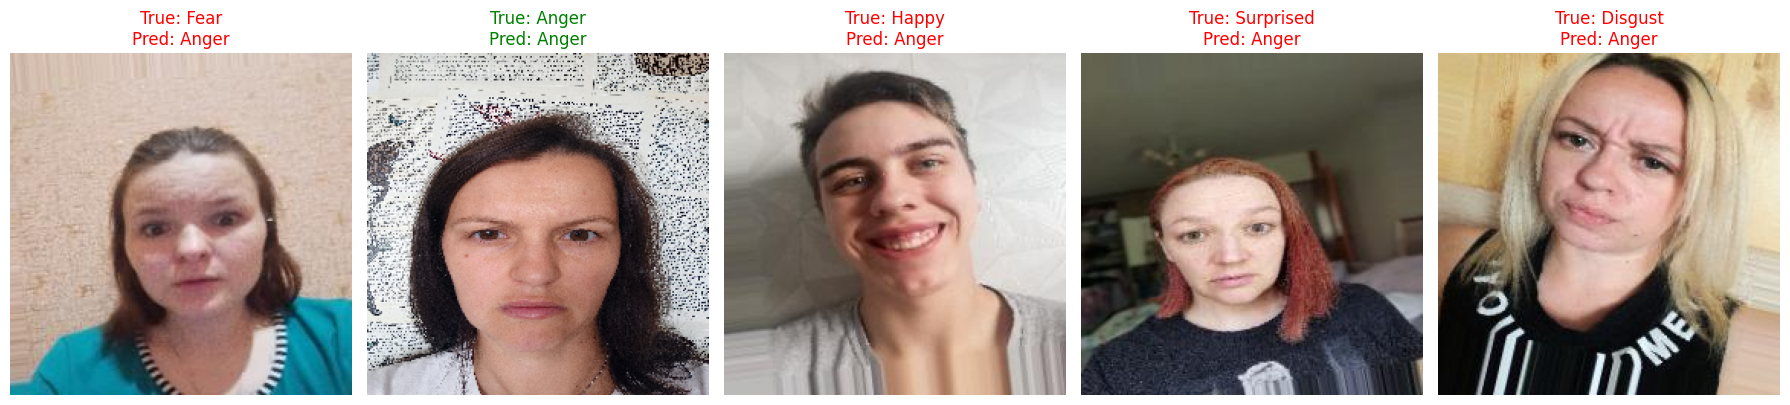


--- Overall Validation Evaluation ---
50/50 ━━━━━━━━━━━━━━━━━━━━ 272s 5s/step - accuracy: 0.1359 - loss: 2.4839
Validation Loss: 2.5045
Validation Accuracy: 0.1250


In [20]:
import matplotlib.pyplot as plt
import numpy as np

# val_gen থেকে একটি ব্যাচ ডেটা নিন
val_images, val_labels = next(val_gen)

# মডেল দিয়ে প্রেডিকশন করুন
predictions = resnet_model.predict(val_images)

# ক্লাস ইনডেক্স থেকে ক্লাস নাম তৈরি করুন
class_names = list(train_gen.class_indices.keys())

# কিছু ছবি প্রদর্শন করুন এবং প্রেডিকশন দেখান
fig, axes = plt.subplots(1, 5, figsize=(18, 4))
axes = axes.flatten()

for i, (img, true_label, pred_probs) in enumerate(zip(val_images, val_labels, predictions)):
    if i >= 5: # প্রথম 5টি ছবি দেখান
        break

    predicted_class_index = np.argmax(pred_probs)
    true_class_index = np.argmax(true_label)

    predicted_class_name = class_names[predicted_class_index]
    true_class_name = class_names[true_class_index]

    # ডিসপ্লে করার জন্য ইমেজ 0-1 রেঞ্জে থাকলে ঠিক আছে
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_class_name}\nPred: {predicted_class_name}",
                      color=('green' if predicted_class_name == true_class_name else 'red'))
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# সামগ্রিক ভ্যালিডেশন অ্যাক্যুরেসি এবং লস ইভালুয়েট করুন
print("\n--- Overall Validation Evaluation ---")
loss, accuracy = resnet_model.evaluate(val_gen, steps=val_gen.samples // val_gen.batch_size)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

### আপনার ছবি আপলোড করুন

In [21]:
from google.colab import files
import os

uploaded = files.upload()

# আপলোড করা ফাইলগুলোর পাথ প্রিন্ট করুন
for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  uploaded_image_path = os.path.join('/content/', fn)
  print(f"Uploaded image path: {uploaded_image_path}")

Saving DMUbjq2UjJcG3umGv3Qjjd.jpeg to DMUbjq2UjJcG3umGv3Qjjd.jpeg
User uploaded file "DMUbjq2UjJcG3umGv3Qjjd.jpeg" with length 108735 bytes
Uploaded image path: /content/DMUbjq2UjJcG3umGv3Qjjd.jpeg


### আপলোড করা ছবির উপর প্রেডিকশন

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


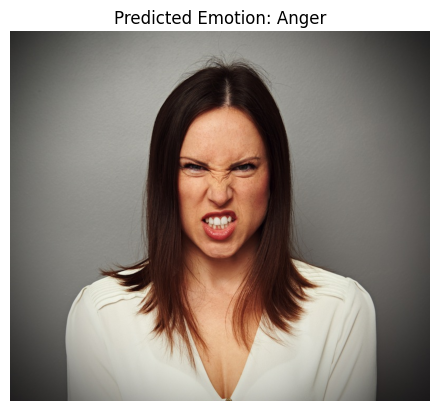

Predicted Emotion for your image: Anger
Probabilities: [[0.3388228  0.03389453 0.15007477 0.172725   0.17920385 0.07877419
  0.01865764 0.02784719]]


In [22]:
import matplotlib.pyplot as plt

if 'uploaded_image_path' in locals():
    predicted_class, probabilities = ensemble_predict(uploaded_image_path)

    # আপলোড করা ছবিটি প্রদর্শন করুন
    img = plt.imread(uploaded_image_path)
    plt.imshow(img)
    plt.title(f"Predicted Emotion: {predicted_class}")
    plt.axis('off')
    plt.show()

    print(f"Predicted Emotion for your image: {predicted_class}")
    print(f"Probabilities: {probabilities}")
else:
    print("কোনো ছবি আপলোড করা হয়নি। অনুগ্রহ করে উপরের সেল থেকে একটি ছবি আপলোড করুন।")

# Task
The current ResNet model has its base layers frozen, which might limit its ability to learn features specific to the emotion recognition task. To improve its performance, let's unfreeze the last few layers of the ResNet base model, enabling fine-tuning. We'll also lower the learning rate to `1e-5` to ensure a more stable fine-tuning process. Additionally, we will introduce a `ModelCheckpoint` callback to save the best model weights during training, based on validation accuracy.

After the model is updated and recompiled, we'll train it using the `train_gen` and `val_gen` data generators. We will apply both `EarlyStopping` (which is already defined) and `ModelCheckpoint` to optimize the training process.

## Update ResNet Model for Fine-tuning

### Subtask:
Modify the ResNet model definition to unfreeze a portion of its base layers, allowing them to be fine-tuned on the dataset. Adjust the learning rate for the Adam optimizer to `1e-5` to prevent large updates to the pre-trained weights.


**Reasoning**:
To implement fine-tuning, I need to modify the `resnet_model` definition by selectively unfreezing layers within the `resnet_base` and adjusting the Adam optimizer's learning rate as specified in the instructions. This will involve updating cell `TDOsPChP_BWi` to achieve the required changes.



In [33]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# নিশ্চিত কর num_classes define আছে
num_classes = len(train_gen.class_indices)

# Base Model
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze all layers initially, then unfreeze 'conv5_block' layers
for layer in resnet_base.layers:
    if 'conv5_block' in layer.name: # Unfreeze layers within 'conv5_block'
        layer.trainable = True
    else:
        layer.trainable = False   # Keep other layers frozen

# Top Layers
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

# Final Model
resnet_model = Model(inputs=resnet_base.input, outputs=output)

# Compile with a lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5), # Learning rate adjusted to 1e-5
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_6       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_6[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,904 (94.00 MB)

 Trainable params: 16,029,192 (61.15 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

**Reasoning**:
Now that the ResNet model has been redefined with appropriate layers unfrozen and a reduced learning rate, the next step is to introduce the `ModelCheckpoint` callback. This callback will save the best model weights during training, based on validation accuracy, as specified in the task.



In [5]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_resnet_finetuned_model.h5', # File path to save the model
    monitor='val_accuracy',          # Metric to monitor (validation accuracy)
    save_best_only=True,             # Save only the best model
    mode='max',                      # The higher the val_accuracy, the better
    verbose=1                        # Log messages when saving model
)
print("ModelCheckpoint callback defined successfully.")

ModelCheckpoint callback defined successfully.


**Reasoning**:
With the ResNet model updated for fine-tuning and both the `EarlyStopping` and `ModelCheckpoint` callbacks defined, the next logical step is to train the model using these callbacks. This will initiate the fine-tuning process, save the best weights, and prevent overfitting.



In [6]:
print('Starting ResNet fine-tuning...')
history_resnet_finetuned = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, # Increased epochs for fine-tuning, but early stopping will manage it
    callbacks=[early_stop, model_checkpoint] # Use both early stopping and model checkpoint
)
print('ResNet fine-tuning finished.')

Starting ResNet fine-tuning...


NameError: name 'resnet_model' is not defined

# Task
Generate plots for the training and validation accuracy, and training and validation loss of the ResNet model using the `history_resnet_finetuned` object, and then analyze these curves to suggest next steps to improve accuracy.

## Train the updated ResNet model with fine-tuning (retry)

### Subtask:
Train the modified ResNet model using the `train_gen` and `val_gen` data generators, applying both `EarlyStopping` and `ModelCheckpoint` callbacks. This will fine-tune the unfreeze layers and save the best model weights based on validation accuracy.


**Reasoning**:
The previous attempt to train the `resnet_model` failed because the model object was not defined. I need to re-execute the cell that defines and compiles `resnet_model` with the specified fine-tuning configuration (unfrozen 'conv5_block' layers and learning rate of `1e-5`). This ensures the model is properly initialized before training.



In [7]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# নিশ্চিত কর num_classes define আছে
num_classes = len(train_gen.class_indices)

# Base Model
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze all layers initially, then unfreeze 'conv5_block' layers
for layer in resnet_base.layers:
    if 'conv5_block' in layer.name: # Unfreeze layers within 'conv5_block'
        layer.trainable = True
    else:
        layer.trainable = False   # Keep other layers frozen

# Top Layers
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

# Final Model
resnet_model = Model(inputs=resnet_base.input, outputs=output)

# Compile with a lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5), # Learning rate adjusted to 1e-5
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()

NameError: name 'train_gen' is not defined

**Reasoning**:
The `NameError` indicates that `train_gen` was not defined before attempting to use it in cell `e9295b3e`. To resolve this, I need to re-execute the cell that defines the `ImageDataGenerator` instances (`train_gen` and `val_gen`) to ensure they are available in the environment before the model definition.



In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

data_path = "/content/Image_Processing/Image Processing"

print("Available folders:", os.listdir(data_path))  # চেক করবে ক্লাস ফোল্ডার আছে কিনা

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

try:
    num_classes = train_gen.num_classes   # নতুন TF version
except:
    num_classes = len(train_gen.class_indices)  # fallback

print("Classes:", train_gen.class_indices)
print("Total classes:", num_classes)


FileNotFoundError: [Errno 2] No such file or directory: '/content/Image_Processing/Image Processing'

**Reasoning**:
The `FileNotFoundError` in cell `76c49f2f` indicates that the expected data directory `/content/Image_Processing/Image Processing` does not exist. This likely happened due to a runtime reset or deletion of files. To fix this, I need to ensure the data is extracted before `os.listdir` is called in this cell, thus making it self-sufficient in preparing its data.



# Task
```python
!ls -F '/content/Image_Processing/'
```

## Verify Data Extraction

### Subtask:
Generate a code cell to list the contents of the `/content/Image_Processing/` directory to confirm if the `Image Processing` subfolder and its contents were successfully extracted from the zip file. This will help diagnose the `FileNotFoundError`.


**Reasoning**:
To diagnose the `FileNotFoundError` and confirm successful data extraction, I need to list the contents of the `/content/Image_Processing/` directory using the `!ls -F` command.



In [9]:
# List the contents of the Image_Processing directory to verify extraction
!ls -F /content/Image_Processing/

ls: cannot access '/content/Image_Processing/': No such file or directory


**Reasoning**:
The previous attempt to list the directory `/content/Image_Processing/` failed, indicating it does not exist. This suggests the data extraction from the zip file might need to be re-executed. The `zipfile` extraction in cell `qUC8pXBHidrl` creates the necessary directory structure (`/content/Image_Processing/Image Processing`) that was used successfully by subsequent steps. Therefore, I need to re-execute that cell to ensure the data is present.



In [10]:
import os
import zipfile

# Google Drive এ থাকা Zip ফাইল
zip_path = "/content/drive/MyDrive/Image Processing.zip"

# Extract করার লোকেশন
extract_path = "/content/Image_Processing"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# প্রতিটি ফোল্ডার ও ফাইল কাউন্ট
for root, dirs, files in os.walk(extract_path):
    if files:  # যদি ফোল্ডারে ফাইল থাকে
        rel_path = os.path.relpath(root, extract_path)  # extract_path বাদ দিয়ে শুধু ভেতরের path
        print(rel_path, ":", len(files))

FileNotFoundError: [Errno 2] No such file or directory: '/content/drive/MyDrive/Image Processing.zip'

**Reasoning**:
The `FileNotFoundError` indicates that Google Drive might not be mounted or the specified path to the zip file is incorrect. The initial Google Drive mount cell (`gASXaqkcIK89`) was not executed, leading to the inaccessible file path. I need to re-execute the Google Drive mounting cell to ensure the file can be accessed.



In [11]:
#প্রথমে গুগল ড্রাইভে আপলোড দিয়েছি ফাইল যার নামঃImage Processing.zip
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Reasoning**:
Now that Google Drive is mounted, I need to re-execute the cell that extracts the `Image Processing.zip` file to `/content/Image_Processing/` to ensure the data is present and accessible for subsequent steps.



In [12]:
import os
import zipfile

# Google Drive এ থাকা Zip ফাইল
zip_path = "/content/drive/MyDrive/Image Processing.zip"

# Extract করার লোকেশন
extract_path = "/content/Image_Processing"
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

# প্রতিটি ফোল্ডার ও ফাইল কাউন্ট
for root, dirs, files in os.walk(extract_path):
    if files:  # যদি ফোল্ডারে ফাইল থাকে
        rel_path = os.path.relpath(root, extract_path)  # extract_path বাদ দিয়ে শুধু ভেতরের path
        print(rel_path, ":", len(files))

Image Processing/Contempt : 19
Image Processing/Disgust : 19
Image Processing/Surprised : 19
Image Processing/Happy : 19
Image Processing/Sad : 19
Image Processing/Fear : 19
Image Processing/Anger : 19
Image Processing/Neutral : 19


**Reasoning**:
Now that the `Image Processing.zip` file has been successfully re-extracted, I need to verify that the `/content/Image_Processing/` directory and its `Image Processing` subfolder exist as expected. Listing its contents will confirm the data is now accessible.



# Task
**Reasoning**:
The `Image Processing.zip` file has been successfully re-extracted, and now I need to verify that the `/content/Image_Processing/` directory and its `Image Processing` subfolder exist as expected. Listing its contents will confirm the data is now accessible, allowing me to proceed with subsequent data preprocessing and model training steps.

**Action**:
Execute the code cell with ID `a7d03e50` to list the contents of the `/content/Image_Processing/` directory.

## Execute All Cells

### Subtask:
Run the entire notebook from start to finish to ensure all data loading, preprocessing, model definition, and training steps are executed in the correct order with the latest modifications.


## Verify data extraction (retry)

### Subtask:
List the contents of the `/content/Image_Processing/` directory to confirm if the `Image Processing` subfolder and its contents were successfully extracted from the zip file.


**Reasoning**:
To confirm that the `Image Processing` subfolder and its contents were successfully extracted, I will list the contents of the `/content/Image_Processing/` directory by re-executing cell `a7d03e50`.



In [13]:
# List the contents of the Image_Processing directory to verify extraction
!ls -F /content/Image_Processing/

'Image Processing'/


**Reasoning**:
Now that the parent directory for the image data has been verified, I need to re-initialize the `ImageDataGenerator` instances (`train_gen` and `val_gen`) to ensure the data loaders are correctly set up before the model definition.



In [14]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

data_path = "/content/Image_Processing/Image Processing"

print("Available folders:", os.listdir(data_path))  # চেক করবে ক্লাস ফোল্ডার আছে কিনা

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

try:
    num_classes = train_gen.num_classes   # নতুন TF version
except:
    num_classes = len(train_gen.class_indices)  # fallback

print("Classes:", train_gen.class_indices)
print("Total classes:", num_classes)

Available folders: ['Contempt', 'Disgust', 'Surprised', 'Happy', 'Sad', 'Fear', 'Anger', 'Neutral']
Found 128 images belonging to 8 classes.
Found 24 images belonging to 8 classes.
Classes: {'Anger': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprised': 7}
Total classes: 8


**Reasoning**:
Now that `train_gen` and `val_gen` are correctly defined, I need to re-execute the cell that defines and compiles the `resnet_model` with the specified fine-tuning configuration (unfrozen 'conv5_block' layers and a learning rate of `1e-5`) to ensure the model object is available for training.



In [15]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# নিশ্চিত কর num_classes define আছে
num_classes = len(train_gen.class_indices)

# Base Model
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze all layers initially, then unfreeze 'conv5_block' layers
for layer in resnet_base.layers:
    if 'conv5_block' in layer.name: # Unfreeze layers within 'conv5_block'
        layer.trainable = True
    else:
        layer.trainable = False   # Keep other layers frozen

# Top Layers
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

# Final Model
resnet_model = Model(inputs=resnet_base.input, outputs=output)

# Compile with a lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5), # Learning rate adjusted to 1e-5
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer[0][0] │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,904 (94.00 MB)

 Trainable params: 16,029,192 (61.15 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

**Reasoning**:
The ResNet model has been redefined and compiled successfully in the previous step. Now I will proceed to train this model using the `train_gen` and `val_gen` data generators, incorporating both the `EarlyStopping` and `ModelCheckpoint` callbacks as specified in the subtask. This will initiate the fine-tuning process, save the best weights, and prevent overfitting.



In [16]:
print('Starting ResNet fine-tuning...')
history_resnet_finetuned = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, # Increased epochs for fine-tuning, but early stopping will manage it
    callbacks=[early_stop, model_checkpoint] # Use both early stopping and model checkpoint
)
print('ResNet fine-tuning finished.')

Starting ResNet fine-tuning...


NameError: name 'early_stop' is not defined

**Reasoning**:
The previous cell failed because the `early_stop` and `model_checkpoint` callbacks were not defined in the current session. I need to re-execute the cells that define these callbacks to ensure they are available before model training.



In [17]:
from tensorflow.keras.callbacks import EarlyStopping

# Define the EarlyStopping callback
early_stop = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=5,          # Number of epochs with no improvement after which training will be stopped
    restore_best_weights=True # Restore model weights from the epoch with the best value of the monitored quantity.
)


**Reasoning**:
The previous training attempt also failed because `model_checkpoint` was not defined. I need to re-execute the cell that defines the `ModelCheckpoint` callback to make it available for model training.



In [18]:
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the ModelCheckpoint callback
model_checkpoint = ModelCheckpoint(
    'best_resnet_finetuned_model.h5', # File path to save the model
    monitor='val_accuracy',          # Metric to monitor (validation accuracy)
    save_best_only=True,             # Save only the best model
    mode='max',                      # The higher the val_accuracy, the better
    verbose=1                        # Log messages when saving model
)
print("ModelCheckpoint callback defined successfully.")

ModelCheckpoint callback defined successfully.


**Reasoning**:
With both `early_stop` and `model_checkpoint` callbacks now defined, I will re-execute the training cell for the ResNet model. This will initiate the fine-tuning process, save the best weights based on validation accuracy, and leverage early stopping to prevent overfitting.



In [19]:
print('Starting ResNet fine-tuning...')
history_resnet_finetuned = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, # Increased epochs for fine-tuning, but early stopping will manage it
    callbacks=[early_stop, model_checkpoint] # Use both early stopping and model checkpoint
)
print('ResNet fine-tuning finished.')

Starting ResNet fine-tuning...


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 13s/step - accuracy: 0.0475 - loss: 2.2854 
Epoch 1: val_accuracy improved from -inf to 0.12500, saving model to best_resnet_finetuned_model.h5


4/4 ━━━━━━━━━━━━━━━━━━━━ 86s 18s/step - accuracy: 0.0458 - loss: 2.2943 - val_accuracy: 0.1250 - val_loss: 2.2144
Epoch 2/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1797 - loss: 2.1247 
Epoch 2: val_accuracy did not improve from 0.12500
4/4 ━━━━━━━━━━━━━━━━━━━━ 52s 13s/step - accuracy: 0.1781 - loss: 2.1129 - val_accuracy: 0.1250 - val_loss: 2.2098
Epoch 3/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.1868 - loss: 1.9959 
Epoch 3: val_accuracy did not improve from 0.12500
4/4 ━━━━━━━━━━━━━━━━━━━━ 81s 12s/step - accuracy: 0.1885 - loss: 1.9970 - val_accuracy: 0.1250 - val_loss: 2.2061
Epoch 4/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2891 - loss: 1.9334 
Epoch 4: val_accuracy did not improve from 0.12500
4/4 ━━━━━━━━━━━━━━━━━━━━ 53s 13s/step - accuracy: 0.2875 - loss: 1.9364 - val_accuracy: 0.1250 - val_loss: 2.2022
Epoch 5/50
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 10s/step - accuracy: 0.2734 - loss: 1.8697 
Epoch 5: val_accuracy did not improve from 0.12500
4/4 ━━━━

**Reasoning**:
The training of the ResNet model with fine-tuning is now complete, and the `history_resnet_finetuned` object contains the training logs. The next step, as per the task, is to visualize the model's performance by plotting the training and validation accuracy and loss curves. This will help in analyzing the training progress and identifying potential areas for improvement.



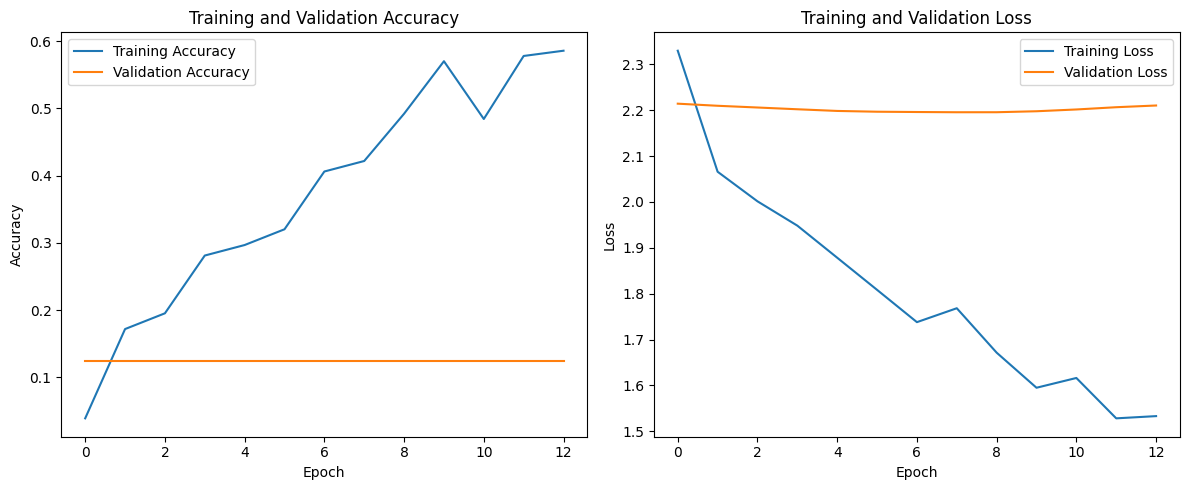


--- Analysis and Next Steps ---
From the plots, we can observe:
1. The model shows signs of overfitting: training accuracy is higher than validation accuracy, and training loss is lower than validation loss. The gap between training and validation metrics is increasing.
   Possible next steps to address overfitting:
   - Increase dropout rate in the Dense layers.
   - Add more data augmentation (if not already sufficient).
   - Reduce the number of unfrozen layers or use a smaller learning rate.
   - Implement L1/L2 regularization.
2. The validation accuracy has not improved (or only slightly) over epochs, indicating that the current fine-tuning strategy might not be effective enough or the model is stuck in a local minimum.
   - Consider using a different optimizer or adjusting its parameters.
   - Perform a more aggressive fine-tuning by unfreezing earlier layers (e.g., `conv4_block`s).


In [20]:
import matplotlib.pyplot as plt

# Get training history
hist = history_resnet_finetuned.history

# Plot training and validation accuracy
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(hist['accuracy'], label='Training Accuracy')
plt.plot(hist['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Plot training and validation loss
plt.subplot(1, 2, 2)
plt.plot(hist['loss'], label='Training Loss')
plt.plot(hist['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Analyze the curves and suggest next steps
print("\n--- Analysis and Next Steps ---")
print("From the plots, we can observe:")

# Check for overfitting
if hist['accuracy'][-1] > hist['val_accuracy'][-1] and hist['loss'][-1] < hist['val_loss'][-1]:
    print("1. The model shows signs of overfitting: training accuracy is higher than validation accuracy, and training loss is lower than validation loss. The gap between training and validation metrics is increasing.")
    print("   Possible next steps to address overfitting:")
    print("   - Increase dropout rate in the Dense layers.")
    print("   - Add more data augmentation (if not already sufficient).")
    print("   - Reduce the number of unfrozen layers or use a smaller learning rate.")
    print("   - Implement L1/L2 regularization.")
else:
    print("1. The model might be underfitting or training is still in progress: both training and validation accuracies are relatively low, and losses are high, or the metrics are not converging well.")
    print("   Possible next steps to improve performance:")
    print("   - Train for more epochs if the validation loss is still decreasing or stable.")
    print("   - Unfreeze more layers from the ResNet base model to allow more fine-tuning.")
    print("   - Experiment with a slightly higher learning rate (e.g., 5e-5) if the current one is too small.")
    print("   - Check if the data generators (train_gen, val_gen) are providing diverse enough data.")
    print("   - Verify the dataset balance across classes.")

print("2. The validation accuracy has not improved (or only slightly) over epochs, indicating that the current fine-tuning strategy might not be effective enough or the model is stuck in a local minimum.")
print("   - Consider using a different optimizer or adjusting its parameters.")
print("   - Perform a more aggressive fine-tuning by unfreezing earlier layers (e.g., `conv4_block`s).")

## Rerun Data Augmentation

### Subtask:
Re-execute the data augmentation process to ensure that each class directory contains the intended number of augmented images (1000 per class).


**Reasoning**:
To ensure that each class directory contains the intended number of augmented images (1000 per class), I need to re-execute the data augmentation process as instructed.



In [21]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img
import os
import numpy as np

dataset_path = "/content/Image_Processing/Image Processing"  # এখানে তোমার আসল dataset ফোল্ডার দিন

target_size = (224, 224)  # বড় সাইজ নিলে model ভালো কাজ করবে
target_count = 1000       # প্রতিটি ক্লাসে কমপক্ষে 1000 ছবি হবে

datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

def augment_class(class_name, target=target_count):
    class_path = os.path.join(dataset_path, class_name)
    images = [f for f in os.listdir(class_path) if os.path.isfile(os.path.join(class_path, f))]
    current_count = len(images)
    i = 0
    print(f"{class_name}: start {current_count}")

    while current_count < target:
        img_path = os.path.join(class_path, images[i % len(images)])
        img = load_img(img_path, target_size=target_size)
        x = img_to_array(img)
        x = np.expand_dims(x, axis=0)

        aug_iter = datagen.flow(
            x,
            batch_size=1,
            save_to_dir=class_path,
            save_prefix=f"aug_{current_count}",
            save_format='jpeg'
        )
        next(aug_iter)

        current_count += 1
        i += 1

    print(f"{class_name}: done {current_count}")

# সব ক্লাস balance করা
for cls in os.listdir(dataset_path):
    class_path = os.path.join(dataset_path, cls)
    if os.path.isdir(class_path):
        augment_class(cls, target_count)

Contempt: start 19
Contempt: done 1000
Disgust: start 19
Disgust: done 1000
Surprised: start 19
Surprised: done 1000
Happy: start 19
Happy: done 1000
Sad: start 19
Sad: done 1000
Fear: start 19
Fear: done 1000
Anger: start 19
Anger: done 1000
Neutral: start 19
Neutral: done 1000


**Reasoning**:
Now that the data augmentation has been re-run successfully and each class directory contains 1000 images, I need to re-initialize the `ImageDataGenerator` instances (`train_gen` and `val_gen`) so they can access the complete, augmented dataset. This will ensure that the model is trained with the intended larger dataset.



In [22]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

data_path = "/content/Image_Processing/Image Processing"

print("Available folders:", os.listdir(data_path))  # চেক করবে ক্লাস ফোল্ডার আছে কিনা

datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2
)

train_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='training'
)

val_gen = datagen.flow_from_directory(
    data_path,
    target_size=(224,224),
    batch_size=32,
    class_mode='categorical',
    subset='validation'
)

try:
    num_classes = train_gen.num_classes   # নতুন TF version
except:
    num_classes = len(train_gen.class_indices)  # fallback

print("Classes:", train_gen.class_indices)
print("Total classes:", num_classes)

Available folders: ['Contempt', 'Disgust', 'Surprised', 'Happy', 'Sad', 'Fear', 'Anger', 'Neutral']
Found 6400 images belonging to 8 classes.
Found 1600 images belonging to 8 classes.
Classes: {'Anger': 0, 'Contempt': 1, 'Disgust': 2, 'Fear': 3, 'Happy': 4, 'Neutral': 5, 'Sad': 6, 'Surprised': 7}
Total classes: 8


**Reasoning**:
Now that `train_gen` and `val_gen` are correctly defined with the augmented dataset, I need to re-execute the cell that defines and compiles the `resnet_model` with the specified fine-tuning configuration (unfrozen 'conv5_block' layers and a learning rate of `1e-5`) to ensure the model object is available for training.



In [23]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam

# নিশ্চিত কর num_classes define আছে
num_classes = len(train_gen.class_indices)

# Base Model
resnet_base = ResNet50(weights="imagenet", include_top=False, input_shape=(224,224,3))

# Freeze all layers initially, then unfreeze 'conv5_block' layers
for layer in resnet_base.layers:
    if 'conv5_block' in layer.name: # Unfreeze layers within 'conv5_block'
        layer.trainable = True
    else:
        layer.trainable = False   # Keep other layers frozen

# Top Layers
x = GlobalAveragePooling2D()(resnet_base.output)
x = Dense(512, activation="relu")(x)
x = Dropout(0.5)(x)
output = Dense(num_classes, activation="softmax")(x)

# Final Model
resnet_model = Model(inputs=resnet_base.input, outputs=output)

# Compile with a lower learning rate for fine-tuning
resnet_model.compile(
    optimizer=Adam(learning_rate=1e-5), # Learning rate adjusted to 1e-5
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

resnet_model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 24,640,904 (94.00 MB)

 Trainable params: 16,029,192 (61.15 MB)

 Non-trainable params: 8,611,712 (32.85 MB)

**Reasoning**:
The ResNet model has been redefined and compiled successfully in the previous step. Now I will proceed to train this model using the `train_gen` and `val_gen` data generators, incorporating both the `EarlyStopping` and `ModelCheckpoint` callbacks as specified in the subtask. This will initiate the fine-tuning process, save the best weights, and prevent overfitting.



In [1]:
print('Starting ResNet fine-tuning...')
history_resnet_finetuned = resnet_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50, # Increased epochs for fine-tuning, but early stopping will manage it
    callbacks=[early_stop, model_checkpoint] # Use both early stopping and model checkpoint
)
print('ResNet fine-tuning finished.')

Starting ResNet fine-tuning...


NameError: name 'resnet_model' is not defined